In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import string
import torch
import torch.nn as nn
import nltk
from tqdm import tqdm

np.random.seed(32)

In [ ]:
contents = []

path = "dataset.txt"

with open(path, "r", encoding="utf-8") as file:
    i = 0
    for line in file:
        if i >= 10000000:
            break
        contents.append(line.lower().split())
        i += 1

print(len(contents))

10000000


In [ ]:
words = []
for line in contents:
    for word in line:
        words.append(word)

print("total words -", len(words))
print("unique words -", len(set(words)))

total words - 114339451
unique words - 563959


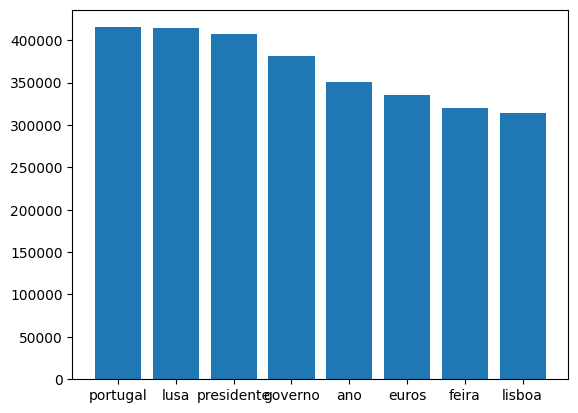

In [ ]:
freq_dist = nltk.FreqDist(words)
plt.figure()
plt.bar(
    x=[x[0] for x in freq_dist.most_common(8)],
    height=[x[1] for x in freq_dist.most_common(8)],
)
plt.show()

In [ ]:
VOCAB_SIZE = 20000
C = 4

vocab = set([w[0] for w in freq_dist.most_common(VOCAB_SIZE)])
word_to_ix = {word: i for i, word in enumerate(sorted(vocab))}
ix_to_word = {i: word for i, word in enumerate(sorted(vocab))}

In [ ]:
data = []

for line in contents:

    word_ix = ["<unk>" if w not in vocab else word_to_ix[w] for w in line]

    if "<unk>" not in word_ix:
        for i in range(C, len(line) - C):
            context = word_ix[i - C : i] + word_ix[i + 1 : i + 1 + C]
            target = word_ix[i]
            data.append((context, target))

print("words -", len(words))
print("sentences -", len(contents))
print("vocab size -", len(vocab))
print("dataset size -", len(data))

words - 114339451
sentences - 10000000
vocab size - 20000
dataset size - 12700122


CBOW

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EMBEDDING_SIZE = 300


class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super(CBOW, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size, max_norm=10)

        self.linear = nn.Linear(embedding_size, vocab_size)

    def forward(self, inputs):
        # inputs : (batch_size x C)
        embedding = self.embedding(inputs).mean(axis=1)
        out = self.linear(embedding)

        return out

In [ ]:
BATCH_SIZE = 32

loss_function = nn.CrossEntropyLoss()
model = CBOW(len(vocab), EMBEDDING_SIZE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

context = torch.tensor([x[0] for x in data])
target = torch.tensor([x[1] for x in data])

dataset = torch.utils.data.TensorDataset(context, target)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True
)

model.to(device)

CBOW(
  (embedding): Embedding(20000, 300, max_norm=10)
  (linear): Linear(in_features=300, out_features=20000, bias=True)
)

In [ ]:
for epoch in range(5):
    train_loss = 0
    test_loss = 0

    progress_bar = tqdm(total=len(train_dataloader))

    """Train"""
    model.train()
    for context, target in train_dataloader:
        context = context.to(device)
        target = target.to(device)

        optimizer.zero_grad()

        out = model(context)
        loss = loss_function(out, target)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        progress_bar.update(1)

    progress_bar.close()

    """Test"""
    model.eval()
    with torch.no_grad():
        for context, target in test_dataloader:
            context = context.to(device)
            target = target.to(device)

            out = model(context)
            test_loss += loss_function(out, target).item()

    print(
        "Epoch -",
        epoch + 1,
        "| Train Loss -",
        train_loss / (len(train_dataset) / BATCH_SIZE),
        "| Test Loss",
        test_loss / (len(test_dataset) / BATCH_SIZE),
    )

100%|██████████| 317504/317504 [18:14<00:00, 290.19it/s]


Epoch - 0 | Train Loss - 6.635367586212214 | Test Loss 6.286344269991585


100%|██████████| 317504/317504 [18:15<00:00, 289.88it/s]


Epoch - 1 | Train Loss - 6.087299757695594 | Test Loss 6.1970714341301045


100%|██████████| 317504/317504 [18:12<00:00, 290.59it/s]


Epoch - 2 | Train Loss - 5.999271332639608 | Test Loss 6.171749750066499


100%|██████████| 317504/317504 [18:12<00:00, 290.72it/s]


Epoch - 3 | Train Loss - 5.964211063440553 | Test Loss 6.156019235851763


100%|██████████| 317504/317504 [18:14<00:00, 290.09it/s]


Epoch - 4 | Train Loss - 5.947253332901212 | Test Loss 6.150370441713518


In [ ]:
model = CBOW(VOCAB_SIZE, EMBEDDING_SIZE).to(device)
model.load_state_dict(torch.load("model_weights10"))
model.eval()

emb_matrix = list(model.parameters())[0]

emb_matrix

Parameter containing:
tensor([[ 1.8600, -0.5842,  0.0111,  ...,  0.5706, -0.2642, -0.3880],
        [-0.3148,  0.2817,  0.1301,  ...,  0.1535, -0.4328, -0.0459],
        [-0.7661,  0.1849,  0.0743,  ...,  0.8035,  0.0177, -0.3972],
        ...,
        [-0.2522,  0.4313, -0.1857,  ...,  0.4312, -0.1504, -1.3942],
        [ 0.3997, -0.6839, -0.5783,  ..., -0.3125, -0.5671,  0.3966],
        [-0.7434, -0.9814,  0.1273,  ..., -0.7991, -0.2330, -0.3072]],
       device='cuda:0', requires_grad=True)